Trainning with W2 loss of gaussianiez patch distrib. 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import resize, to_tensor, to_pil_image
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import random
import numpy as np



In [14]:

device_cuda = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype_fp64 = torch.float64
print(device_cuda)


mps


In [15]:
path = "images/zebra.png"
im = Image.open(path).convert("RGB")
im_tensor_cuda = to_tensor(im)
print(f"inital tensor size : {im_tensor_cuda.shape}")


max_dim = 250
_, H, W = im_tensor_cuda.shape
scale_factor = max_dim / max(H, W)

new_H = int(H * scale_factor)
new_W = int(W * scale_factor)
im_resized = resize(im_tensor_cuda.unsqueeze(0), size=[new_H, new_W], antialias=True).squeeze(0) *2 -1

print(f"rescaled tensor size : {im_resized.shape}")

inital tensor size : torch.Size([3, 380, 572])
rescaled tensor size : torch.Size([3, 166, 250])


In [16]:
min_dim = 25            # dimension mini au coarse scale
N = 0
current_H, current_W = new_H, new_W
r = 4 / 3               # scaling factor (environ 1.333)

# Calculer N tel que le coarse scale soit >= min_dim
while current_H >= min_dim and current_W >= min_dim:
    N += 1
    current_H = int(current_H / r)
    current_W = int(current_W / r)
N

7

In [5]:
scales = [im_resized.unsqueeze(0)]    # niveau 0 = fine

for i in range(0, N):
    prev = scales[-1]
    _, _, h, w = prev.shape
    new_h = max(int(h / r), 1)
    new_w = max(int(w / r), 1)
    down = resize(prev, size=[new_h, new_w], antialias=True)
    scales.append(down)


Number of scales N = 7
Scaling factor r = 1.333
Scale 0 : torch.Size([1, 3, 166, 250])


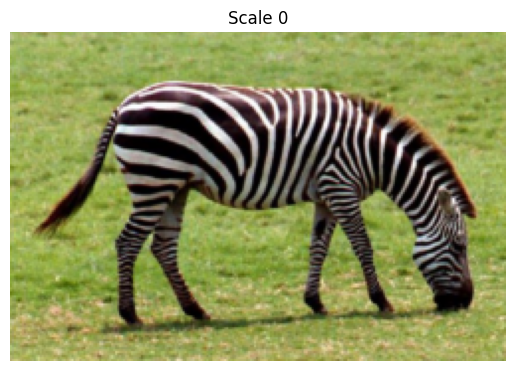

Scale 1 : torch.Size([1, 3, 124, 187])


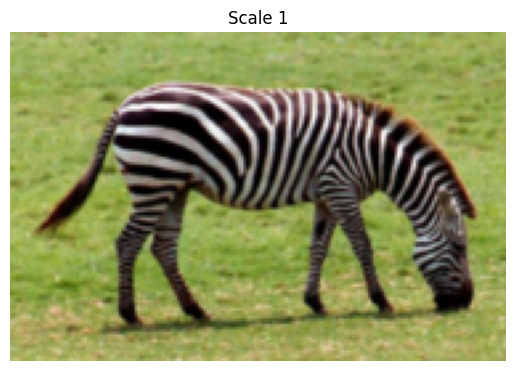

Scale 2 : torch.Size([1, 3, 93, 140])


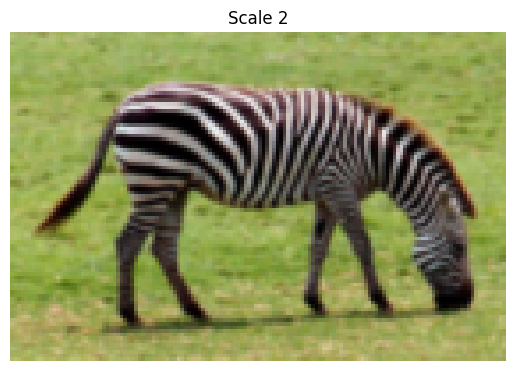

Scale 3 : torch.Size([1, 3, 69, 105])


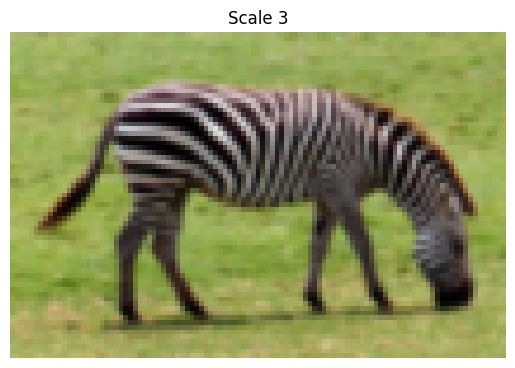

Scale 4 : torch.Size([1, 3, 51, 78])


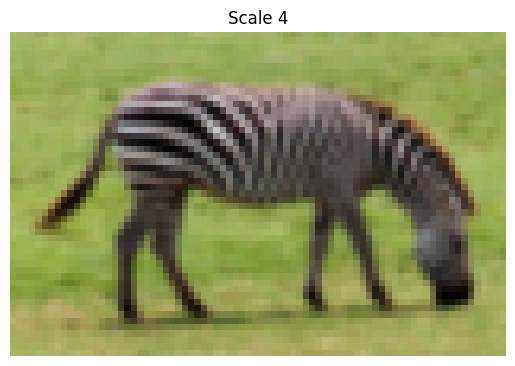

Scale 5 : torch.Size([1, 3, 38, 58])


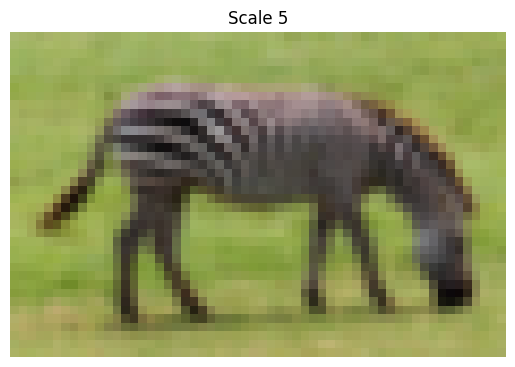

Scale 6 : torch.Size([1, 3, 28, 43])


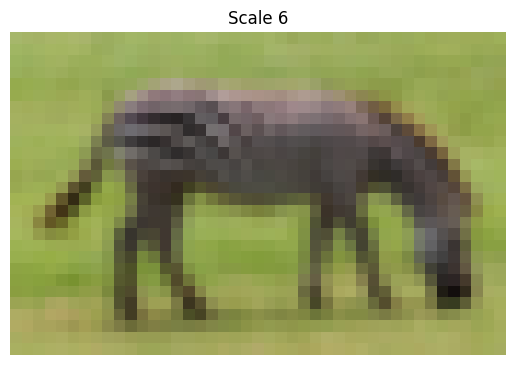

Scale 7 : torch.Size([1, 3, 21, 32])


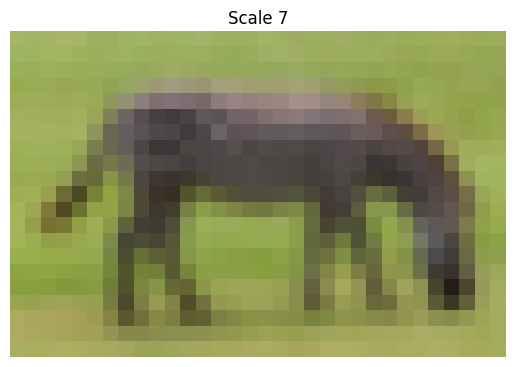

In [6]:
def pil_from_minus1to1(t):
    """
    Convertit un tenseur [-1,1] (CHW ou 1,C,H,W) en PIL Image.
    """
    t = t.squeeze(0) if t.dim() == 4 else t          # B×C×H×W → C×H×W
    t = ((t.clamp(-1, 1) + 1) / 2)                   # [-1,1] → [0,1]
    return to_pil_image(t.cpu())



print(f"Number of scales N = {N}")
print(f"Scaling factor r = {r:.3f}")
for i, im_scale in enumerate(scales):
    print(f"Scale {i} : {im_scale.shape}")
    plt.imshow(pil_from_minus1to1(im_scale.squeeze().cpu()))
    plt.axis('off')
    plt.title(f"Scale {i}")
    plt.show()


In [7]:
class Generator(nn.Module):
    
    def __init__(self,n_hidden):
        super().__init__()
        self.n_hidden = n_hidden
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.n_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            # Last conv layer outputs 3 channels (RGB), no batchnorm or activation
            nn.Conv2d(self.n_hidden, 3, 3, padding=1),
            nn.Tanh()
        )
        
    def forward(self,input):
        return self.main(input)

In [8]:
input_size_visu = (3, 1024, 1024)
netG_visu = Generator(n_hidden=32).to("cpu")
torchsummary.summary(netG_visu, input_size=input_size_visu,device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 3, 1024, 1024]             867
             Tanh-14        [-1, 3, 102

+ Générations des generateurs/discriminateurs

In [9]:
hidden_lowest_dim = 32
Genarators = []

for i in range(len(scales)):
    u = N-i
    Genarators.append(Generator( hidden_lowest_dim *  2**(u//4)).to(device_cuda))
    
Genarators.reverse()

for gen in Genarators : 
     print(gen.n_hidden)



32
32
32
32
64
64
64
64


In [10]:
def extract_patches(img, patch_size, stride):
    
    img_batch = img.unsqueeze(0)  # (1, C, H, W)
    patches = torch.nn.functional.unfold(img_batch, kernel_size=patch_size, stride=stride)
    patches = patches.squeeze(0).T  # (num_patches, C*patch_size*patch_size)
   
    return patches

def get_gaussian_params(patches, debug=True):
    # patches: Tensor (N, D)
    
    mu = patches.mean(dim=0)
    centered = patches - mu
    Sigma = (centered.T @ centered) / (patches.shape[0] - 1)
    
    return mu, Sigma

def matrix_sqrt_eig(mat, eps=1e-10, debug=True):
    """
    Symmetric square root of an SPD matrix via eigen-decomposition.
    """
    # 1) Enforce perfect symmetry
    mat = (mat + mat.T) / 2

    # 2) Eigen-decomposition
    vals, vecs = torch.linalg.eigh(mat)
    # 3) Clamp to avoid tiny negatives, then sqrt
    vals = torch.clamp(vals, min=eps)
    sqrt_mat = vecs @ torch.diag(torch.sqrt(vals)) @ vecs.T

    # 4) Re-symmetrize result
    sqrt_mat = (sqrt_mat + sqrt_mat.T) / 2
    

    return sqrt_mat

def wasserstein_2_gaussian_eig(mu1, Sigma1, mu2, Sigma2, eps=1e-12, debug=False):
    """
    Computes W2^2 between two Gaussians (mu1, Sigma1) and (mu2, Sigma2),
    using a robust eigen-based sqrt.
    """
    # Mean term
    diff_mu_sq = torch.norm(mu1 - mu2)**2
    if debug:
        print("moyenne diff =", diff_mu_sq.item())

    # double sinon pas assez précis. 
    A = Sigma1 + eps * torch.eye(Sigma1.size(0), device=Sigma1.device,dtype=torch.float64)
    S1 = matrix_sqrt_eig(A, eps=eps, debug=debug)

    # Inner product √(S1 Σ2 S1)
    prod = S1 @ Sigma2 @ S1
    S2 = matrix_sqrt_eig(prod, eps=eps, debug=debug)

    # Trace term
    trace_term = torch.trace(Sigma1 + Sigma2 - 2 * S2)
    if debug:
        print("trace term =", trace_term.item())

    return diff_mu_sq + trace_term


In [11]:


inception = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT,
                                transform_input=False).to(device_mps).eval()

inception.eval()

# Choose a layer whose activation map we will use as patch-features.
# For torchvision Inception-v3, use 'Mixed_7c' or an earlier mixed block.
# We register a forward hook to capture its output.
layer_name = 'Mixed_7c'
features_real = []
features_fake = []

def get_module_by_name(model, name):
    for n, module in model.named_modules():
        if n == name:
            return module
    raise ValueError(f"Layer {name} not found")

# Hook function will collect activation maps
def hook_fn_real(module, input, output):
    # output shape: (B, C, H', W')
    feat = output.detach()  # (1, C, H', W')
    # Flatten spatial dims: (C, H'*W') -> (H'*W', C)
    B, C, Hf, Wf = feat.shape
    feat = feat.view(B, C, Hf * Wf).permute(0, 2, 1).squeeze(0)  # (H'*W', C)
    features_real.append(feat)

def hook_fn_fake(module, input, output):
    B, C, Hf, Wf = output.shape
    feat = output.detach().view(B, C, Hf * Wf).permute(0, 2, 1).squeeze(0)
    features_fake.append(feat)

# Register hooks
layer_module = get_module_by_name(inception, layer_name)
hook_handle_real = layer_module.register_forward_hook(hook_fn_real)
hook_handle_fake = layer_module.register_forward_hook(hook_fn_fake)

# Preprocessing for full image: resize to 299x299 and normalize
preprocess_full = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Lambda(lambda t: (t + 1) / 2 if t.min() < 0 else t),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def compute_patch_fid_feature_map(real_img, fake_img, eps=1e-12):
    """
    real_img, fake_img: Tensors of shape (C, H, W), in [-1,1] or [0,1].
    Returns: patch-FID^2 (W2^2) between feature-map distributions.
    """
    # Clear previous feature lists
    features_real.clear()
    features_fake.clear()

    # Preprocess and forward-pass real image
    inp_real = preprocess_full(real_img.unsqueeze(0).to(device_cuda))
    _ = inception(inp_real)
    feat_real = features_real[-1].double()  # (N_real_patches, D)

    # Preprocess and forward-pass fake image
    features_fake.clear()
    inp_fake = preprocess_full(fake_img.unsqueeze(0).to(device_cuda))
    _ = inception(inp_fake)
    feat_fake = features_fake[-1].double()  # (N_fake_patches, D)

    # Compute Gaussian params
    mu_r, Sigma_r = get_gaussian_params(feat_real)
    mu_f, Sigma_f = get_gaussian_params(feat_fake)

    # Compute W2^2
    w2sq = wasserstein_2_gaussian_eig(mu_r, Sigma_r, mu_f, Sigma_f, eps=eps)
    return float(w2sq.item())

+ Boucle d'entrainement 

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1 or classname.find('InstanceNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)




it scale 7:   0%|          | 0/2000 [00:00<?, ?it/s]

[scale 7 | it 0]  L_W2 ≈ 1195.65
[scale 7 | it 0]  L_rec ≈ 0.08
[scale 7 | it 0]  LR = 5.00e-04


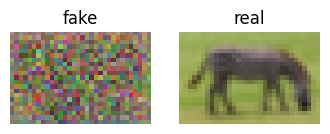

KeyboardInterrupt: 

In [13]:
torch.random.manual_seed(0)

# params
lambda_gp    = 10
lr             = 5e-4 # celui du github
betas            = (0.5, 0.999) # pareil
n_Discriminator  = 5 # pif
n_Generator      = 2 # pif
iter_per_scale   = 2000 # github
alpha_rec      = 10 # gith
beta_sigma   = 0.1 # git
debug          = True
b          = 1  # batch size   
N = len(scales)


for G in Genarators:
    G.apply(weights_init)


# reset des optim.
optimizer_G = []
for i in range(N):
    optimizer_G.append(optim.Adam(Genarators[i].parameters(), lr=lr, betas=betas))

# --- LR schedulers -----------------------------------------------------------
# Each StepLR will keep the LR unchanged for 1 600 iterations, then multiply it
# by 0.1 once, and keep the new value for the remaining ~400 iterations.
scheduler_G = [] 

step_size   = 1600          # when to trigger the decay
gamma       = 0.1            # multiplicative factor

for opt_G in optimizer_G :
    scheduler_G.append(
        torch.optim.lr_scheduler.StepLR(opt_G, step_size=step_size, gamma=gamma)
    )
   


z_star   = torch.randn_like(scales[-1])               # bruit fixe
sigma_n  = [1.] * N
x_rec    = [None] * N
gen_image = [torch.zeros_like(scales[-1]).to(device_cuda)]
       


@torch.no_grad()
def regenerate_prev_full(k):
    """
    Reconstruit un prev_img pour l'échelle k en:
      +  partant d'une image nulle au coarse (N-1),
      + appliquant *tous* les G gelés (N-1 … k+1) avec nouveau bruit,
      +  upsamplant le résultat (k+1) → résolution de k.
    """
    if k == N-1:                                    # échelle coarse → zeros
        return torch.zeros_like(scales[k]).to(device_cuda)

    # scale la plus petite
    img = torch.zeros_like(scales[-1]).to(device_cuda)   
    z   = torch.randn_like(img) * sigma_n[N-1]
    img = Genarators[N-1](z)                       

    # on remonte le réseau
    for s in range(N-2, k, -1):                     
        img_up = F.interpolate(img,
                               size=scales[s].shape[2:],
                               mode='bilinear', align_corners=False)
        z      = torch.randn_like(img_up) * sigma_n[s]
        img    = Genarators[s](z + img_up) + img_up

    prev_img = F.interpolate(img,
                             size=scales[k].shape[2:],
                             mode='bilinear', align_corners=False)
    return prev_img

# trainning toutes les scales
for n in range(N):
    current_res  = N - n - 1          
    Gk = Genarators[current_res].train()
    xk_real = scales[current_res].to(device_cuda)
    
    
    if current_res < N-1:                          
        G_prev = Genarators[current_res + 1]

        def same_channels(net_a, net_b):
            """return True if first conv out-channels match"""
            for m_a, m_b in zip(net_a.modules(), net_b.modules()):
                if isinstance(m_a, torch.nn.Conv2d):
                    return m_a.out_channels == m_b.out_channels
            return False

        if same_channels(Gk, G_prev):              
            Gk.load_state_dict(G_prev.state_dict(), strict=True)
            if debug:
                print(f"[init] copied weights from scale {current_res+1} → {current_res}")

    # NB: from here on, use *Gk* / *Dk*; they already sit in the
    #     Genarators / Discriminators lists, so nothing else changes.
    Gk.train()
    # (re-attach the optimisers in case parameters were just overwritten)
    opt_G = optimizer_G[current_res]
  
    

# Calcul ecart type nécessaire pour le bruit.
    if current_res < N-1:
        up_rec = F.interpolate(x_rec[current_res+1],
                               size=xk_real.shape[2:], mode='bilinear', align_corners=False)

        # σ_n = β · RMSE((x_rec[n+1]↑), x_n) / RMSE(0, x_n) # formule trouvé je sais plus ou. 
        num   = F.mse_loss(up_rec, xk_real)             
        denom = F.mse_loss(torch.zeros_like(xk_real), xk_real)
        sigma_n[current_res] = beta_sigma * torch.sqrt(num / denom)   
    else:
        sigma_n[current_res] = torch.tensor(1, device=device_cuda)

    # itérations par scale
    for it in tqdm(range(iter_per_scale), desc=f"it scale {current_res}", leave=False):

        # prev_img tiré fraichement
        with torch.no_grad():
            prev_img = regenerate_prev_full(current_res)

        for g_idx in range(n_Generator):
            opt_G.zero_grad()
            z = torch.randn_like(prev_img) * sigma_n[current_res]
            fake = Gk(z + prev_img) + prev_img

            # ----- Reconstruction eq. 5 -----
            if current_res == N-1:                         # coarse
                rec_in = z_star                             # MOD (z_star)
                rec_out = Gk(rec_in)                       # pas de upsample
            else:                                          # n < N
                up_fixed = F.interpolate(x_rec[current_res+1],
                                          size=xk_real.shape[2:], mode='bilinear', align_corners=False)
                rec_in = up_fixed                          # MOD (bruit = 0)
                rec_out = Gk(rec_in) + up_fixed            # MOD

            Lrec = F.mse_loss(rec_out, xk_real)
            L_W2 = compute_patch_fid_feature_map(xk_real.squeeze(),fake.squeeze())
            (L_W2+ alpha_rec * Lrec).backward()
            opt_G.step()
        
        # ---- advance LR scheduler *once* for this outer iteration
        scheduler_G[current_res].step()
        
        # logs
        if debug and (it % 200 == 0 or it==iter_per_scale-1):
            # pas de torch.no_grad() ici : on a besoin du backward dans lipconstant
            print(f"[scale {current_res} | it {it}]  L_W2 ≈ {L_W2:.2f}")
            print(f"[scale {current_res} | it {it}]  L_rec ≈ {Lrec:.2f}")
            current_lr = opt_G.param_groups[0]['lr']
            print(f"[scale {current_res} | it {it}]  LR = {current_lr:.2e}")

            with torch.no_grad():                     # on garde no_grad pour l’affichage
                plt.figure(figsize=(4,2))
                plt.subplot(1,2,1); plt.imshow(pil_from_minus1to1(fake[0].cpu())); plt.axis('off'); plt.title('fake')
                plt.subplot(1,2,2); plt.imshow(pil_from_minus1to1(xk_real[0].cpu()));        plt.axis('off'); plt.title('real')
                plt.show()
    # fige G_k et stocke fake pour l’échelle au-dessus 
    with torch.no_grad():
        gen_image.append(fake.detach())
        if current_res == N-1:
            x_rec[current_res] = Gk(z_star)                              # NEW (bruit fixe)
        else:
            up_rec_k = F.interpolate(x_rec[current_res+1], size=xk_real.shape[2:], mode='bilinear', align_corners=False)
            x_rec[current_res] = Gk(up_rec_k) + up_rec_k                 # NEW (bruit 0)
        Gk.eval()
        for p in Gk.parameters(): 
            p.requires_grad_(False)


SAVING GENERATORS AND OR LOADING OTHERS

In [14]:
# ==== SAVE GENERATORS ========================================================
import os, datetime, torch, json

model_name = "basic" 
image_name = "zebre"                   
model_dir  = os.path.join("models", image_name,model_name)
weights_fp = os.path.join(model_dir, "generators.pt")
descr_fp   = os.path.join(model_dir, "Description.txt")
sigma_fp   = os.path.join(model_dir, "sigma_n.json")
zstar_fp   = os.path.join(model_dir, "z_star.pt")    # ← chemin pour z_star

if os.path.exists(model_dir):
    print(f"ATTENTION : Un modèle nommé '{model_name}' existe déjà dans '{model_dir}'.")
    print("   → Choisis un autre nom pour ne pas l'écraser.")
else:
    os.makedirs(model_dir, exist_ok=True)

    # 1) sauvegarde des poids : liste d'état (un par G_k)
    torch.save([G.state_dict() for G in Genarators], weights_fp)

    # 2) petit fichier description (texte lisible)
    description = {
        "date"           : datetime.datetime.now().isoformat(timespec="seconds"),
        "N"              : N,
        "lambda_gp"      : lambda_gp,
        "r"                 : float(r),
        "lr"             : lr,
        "betas"          : betas,
        "n_Discriminator": n_Discriminator,
        "n_Generator"    : n_Generator,
        "iter_per_scale" : iter_per_scale,
        "alpha_rec"      : alpha_rec,
        "beta_sigma"     : beta_sigma,
        "comment"        : "Sin Gan avec poids classique comme dans le papier sauf le padding",
    }
    with open(descr_fp, "w", encoding="utf-8") as f:
        for k, v in description.items():
            f.write(f"{k}: {v}\n")

    # 3) sauvegarde de la liste sigma_n
    sigma_list = []
    for s in sigma_n:
        # si s est un tensor scalaire, on fait s.item(), sinon on lève une erreur
        if torch.is_tensor(s):
            sigma_list.append(s.item())
        else:
            sigma_list.append(float(s))
    with open(sigma_fp, "w", encoding="utf-8") as f:
        json.dump(sigma_list, f)


    # 4) génération et sauvegarde de z_star
    #    remplace (h, w) par la forme souhaitée
    torch.save(z_star, zstar_fp)

    print(f"Générateurs sauvegardés     -> {weights_fp}")
    print(f"Description créée           -> {descr_fp}")
    print(f"sigma_n sauvegardé          -> {sigma_fp}")
    print(f"z_star sauvegardé           -> {zstar_fp}")


Générateurs sauvegardés     -> models/zebre/basic/generators.pt
Description créée           -> models/zebre/basic/Description.txt
sigma_n sauvegardé          -> models/zebre/basic/sigma_n.json
z_star sauvegardé           -> models/zebre/basic/z_star.pt


In [15]:
# ===================== LOAD A CHECKPOINT, WHATEVER IS IN MEMORY =====================
import os, torch
import json  # pour sigma_n

# --- (1) nom du modèle à charger -----------------------------------------------------
image_name = "zebre"
model_name = "basic"
model_dir  = os.path.join("models",image_name ,model_name)
weights_fp = os.path.join(model_dir, "generators.pt")
descr_fp   = os.path.join(model_dir, "Description.txt")
sigma_fp   = os.path.join(model_dir, "sigma_n.json")
zstar_fp   = os.path.join(model_dir, "z_star.pt")  

if not os.path.exists(weights_fp):
    raise FileNotFoundError(f"Impossible de trouver le fichier : {weights_fp}")

# --- (2) on lit la liste de state_dict ----------------------------------------------
state_list = torch.load(weights_fp, map_location="cpu")
print(f"{len(state_list)} générateurs trouvés dans le checkpoint")

# (facultatif) on affiche le petit fichier description
if os.path.isfile(descr_fp):
    print("─── Description.txt ───")
    with open(descr_fp, encoding="utf-8") as f:
        print(f.read().strip())
    print("────────────────────────\n")

# --- (2bis) on charge la liste sigma_n ----------------------------------------------
if os.path.isfile(sigma_fp):
    with open(sigma_fp, "r", encoding="utf-8") as f:
        loaded_sigma_n = json.load(f)
    print(f"sigma_n chargé ({len(loaded_sigma_n)} éléments) → 'loaded_sigma_n'")
else:
    raise FileNotFoundError(f"Impossible de trouver le fichier sigma_n : {sigma_fp}")

# --- (2ter) on charge z_star -------------------------------------------------------
if os.path.isfile(zstar_fp):
    loaded_z_star = torch.load(zstar_fp, map_location="cpu")
    print(f"z_star chargé de taille {tuple(loaded_z_star.shape)} → 'loaded_z_star'")
else:
    raise FileNotFoundError(f"Impossible de trouver le fichier z_star : {zstar_fp}")

# --- (3) fonction helper : recrée un Generator adapté au state_dict -----------------
def build_generator_from_state(sd, device="cpu"):
    for key in sd.keys():
        if key.endswith(".weight") and sd[key].dim() == 4:
            n_hidden = sd[key].shape[0]
            break
    else:
        raise KeyError("Impossible d'inférer n_hidden depuis le state_dict.")
    G = Generator(n_hidden).to(device)
    G.load_state_dict(sd, strict=True)
    G.eval()
    for p in G.parameters():
        p.requires_grad_(False)
    return G

# --- (4) on construit la liste des générateurs chargés ------------------------------
device = torch.device("cpu")
loaded_generators = [build_generator_from_state(sd, device=device) for sd in state_list]

print(f"{len(loaded_generators)} générateurs instanciés → 'loaded_generators'")


8 générateurs trouvés dans le checkpoint
─── Description.txt ───
date: 2025-06-02T13:39:24
N: 8
lambda_gp: 10
r: 1.3333333333333333
lr: 0.0005
betas: (0.5, 0.999)
n_Discriminator: 5
n_Generator: 2
iter_per_scale: 2000
alpha_rec: 10
beta_sigma: 0.1
comment: Sin Gan avec poids classique comme dans le papier sauf le padding
────────────────────────

sigma_n chargé (8 éléments) → 'loaded_sigma_n'
z_star chargé de taille (1, 3, 21, 32) → 'loaded_z_star'
8 générateurs instanciés → 'loaded_generators'


In [16]:
@torch.no_grad()
def generate_multiscale(start_scale: int = N - 1,Generators = Genarators):
    """
    start_scale = 0  → on ne renouvelle le bruit qu’à la fine scale
    start_scale = N-1→ on renouvelle le bruit à toutes les échelles
    """
    # Génération totale
    if start_scale == N-1 : 
        h, w = scales[-1].shape[2:]
        gen_image = [torch.zeros((1, 3, h, w), device=device)]

         # 2. on remonte coarse → fine
        for i in range(N):
            k = N - 1 - i                    
        
            prev = gen_image[-1]
            if prev.shape[2:] != scales[k].shape[2:]:
                prev = F.interpolate(prev, size=scales[k].shape[2:],
                                    mode='bilinear', align_corners=False)

            z = torch.randn_like(prev) * sigma_n[k]
            

            x_k = Generators[k](z + prev) + prev
            gen_image.append(x_k)

        

    else : 
        low = scales[start_scale+1] 
        up = F.interpolate(low, size=scales[start_scale].shape[2:],
                                    mode='bilinear', align_corners=False)
        gen_image = [up]

         # 2. on remonte coarse → fine
        for scale in range(start_scale,-1,-1):
                            
            prev = gen_image[-1]
            if prev.shape[2:] != scales[scale].shape[2:]:
                prev = F.interpolate(prev, size=scales[scale].shape[2:],
                                    mode='bilinear', align_corners=False)

            z = torch.randn_like(prev) * sigma_n[scale]
            x_k = Genarators[scale](z + prev) + prev
            gen_image.append(x_k)

    
    return gen_image[1:]
        
    


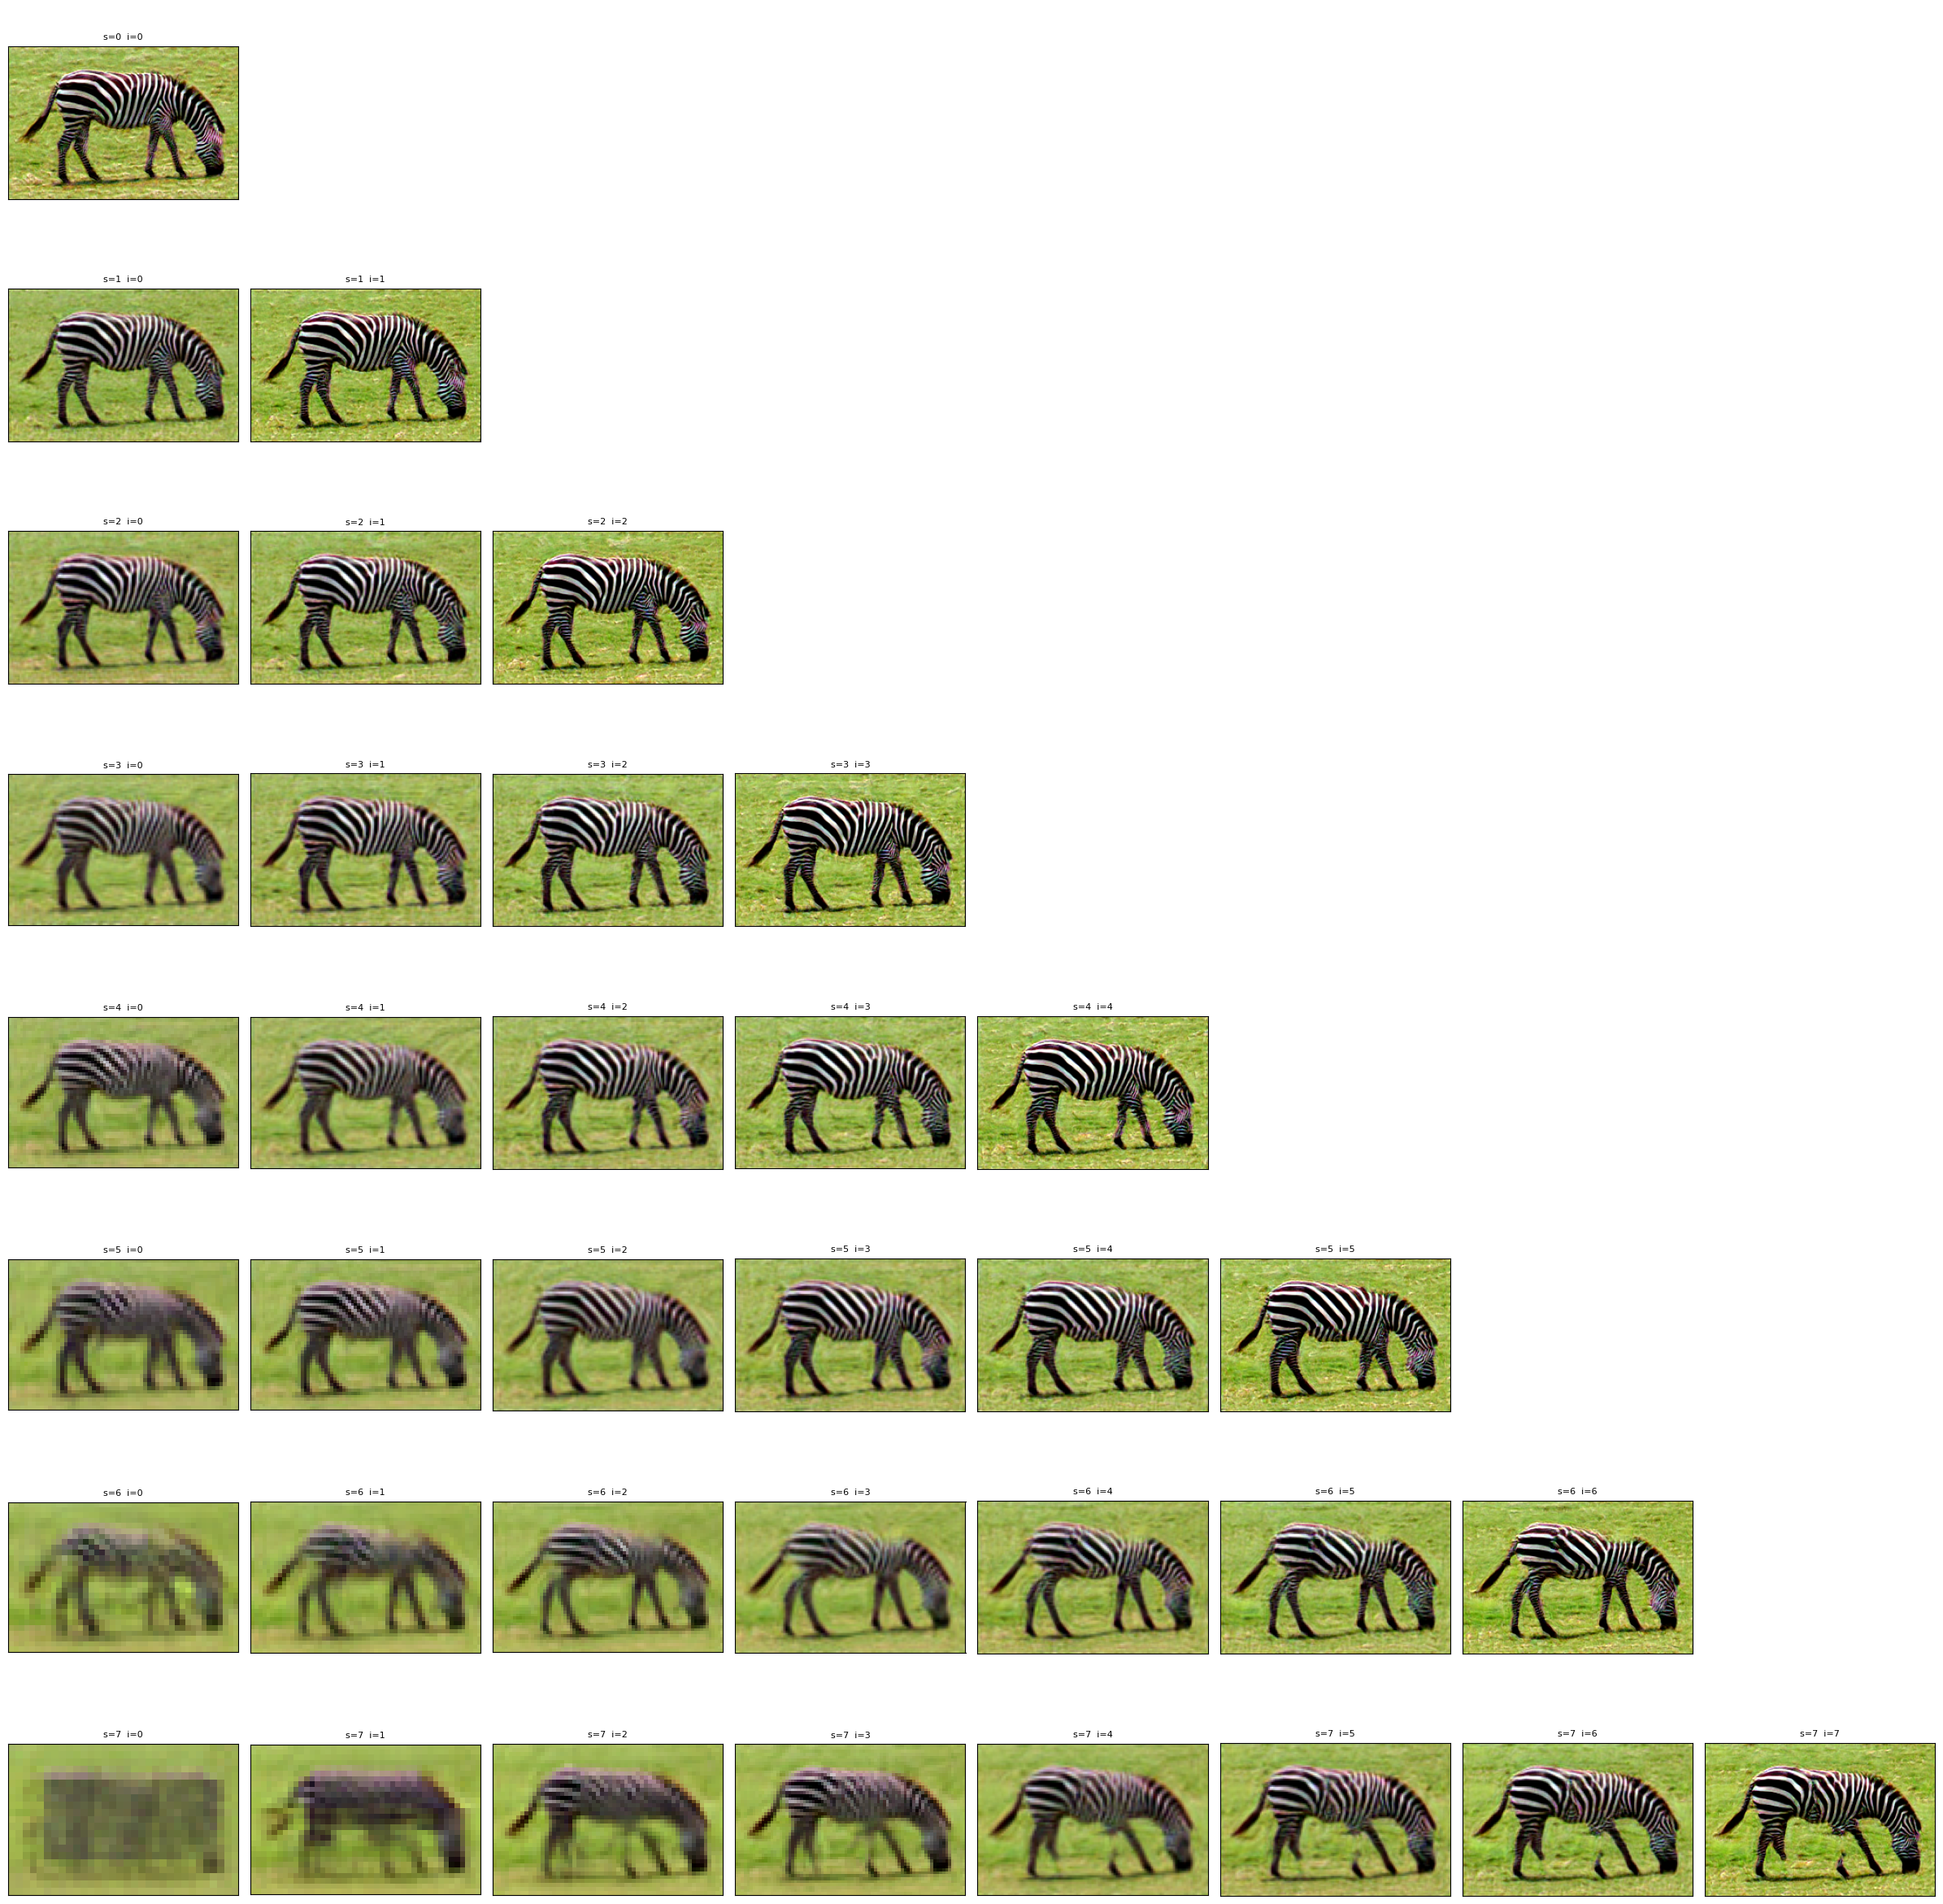

In [17]:
# 1. Collecter toutes les images pour connaître la taille de la grille
rows      = []                 # liste des listes d’images (Tensor)
max_cols  = 0
for s in range(N):
    imgs = generate_multiscale(start_scale=s,Generators=loaded_generators)   # list[Tensor]
    rows.append(imgs)
    max_cols = max(max_cols, len(imgs))

# 2. Créer la figure
cell = 3.0                     # taille (pouces) d’une cellule
fig_w, fig_h = cell * max_cols, cell * N
fig, axes = plt.subplots(N, max_cols, figsize=(fig_w, fig_h), squeeze=False)

# 3. Remplir le tableau
for r, (s, imgs) in enumerate(zip(range(N), rows)):
    for c in range(max_cols):
        ax = axes[r, c]

        if c < len(imgs):
            img_pil = pil_from_minus1to1(imgs[c].cpu().squeeze())
            
            ax.imshow(img_pil)
            ax.set_title(f"s={s}  i={c}", fontsize=8)
        else:
            ax.axis('off')          # cellule vide

        ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()

saved → outputs/trash/gen_20250602_144521_1.png
saved → outputs/trash/gen_20250602_144521_2.png
saved → outputs/trash/gen_20250602_144521_3.png
saved → outputs/trash/gen_20250602_144521_4.png
saved → outputs/trash/gen_20250602_144521_5.png
saved → outputs/trash/gen_20250602_144521_6.png
saved → outputs/trash/gen_20250602_144521_7.png
saved → outputs/trash/gen_20250602_144521_8.png


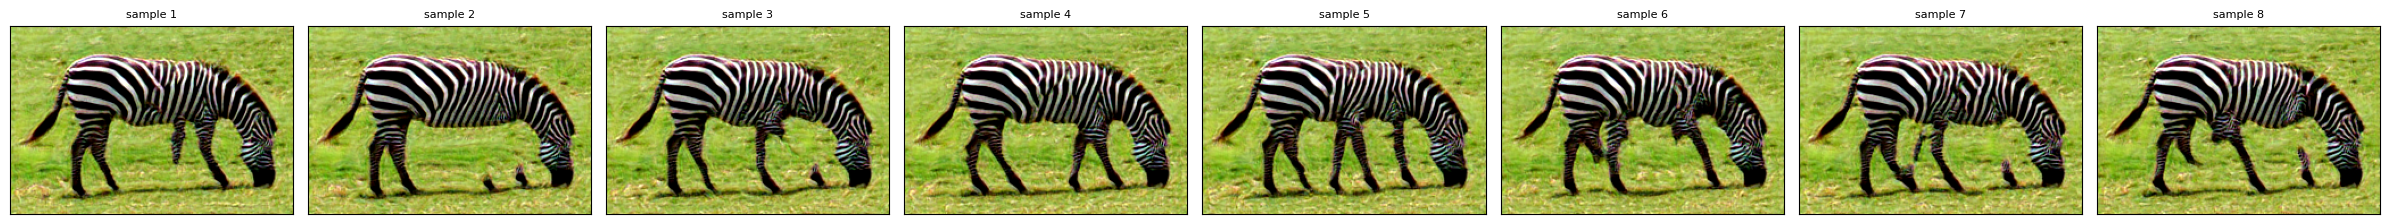

In [27]:
import torchvision.utils as vutils
import os, time

# dossier de sortie
out_dir = "outputs/trash"
os.makedirs(out_dir, exist_ok=True)

# Nombre de générations
K = 8
final_imgs = []
for k in range(K):
    imgs = generate_multiscale(start_scale=N-1,Generators=loaded_generators)
    final_imgs.append(imgs[-1].cpu().squeeze())      # dernière image

# affichage + sauvegarde
cell = 3.0
fig, axes = plt.subplots(1, K, figsize=(cell*K, cell), squeeze=False)

for idx, (ax, img) in enumerate(zip(axes[0], final_imgs), 1):
    # plot
    ax.imshow(pil_from_minus1to1(img))
    ax.set_title(f"sample {idx}", fontsize=8)
    ax.set_xticks([]); ax.set_yticks([])

    # sauvegarde
    img_01 = ((img.clamp(-1, 1) + 1) / 2)            # [-1,1] → [0,1]
    filename = os.path.join(
        out_dir, f"gen_{time.strftime('%Y%m%d_%H%M%S')}_{idx}.png"
    )
    vutils.save_image(img_01, filename)
    print(f"saved → {filename}")

plt.tight_layout()
plt.show()


Reconstruction de XREC

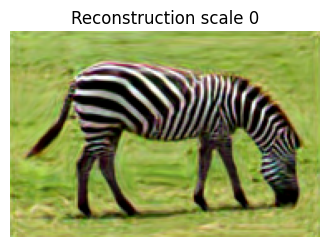

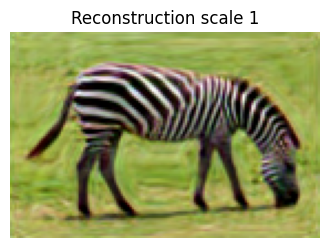

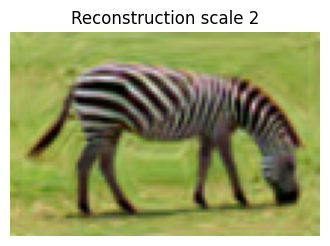

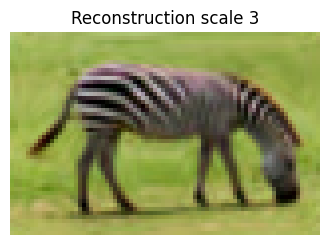

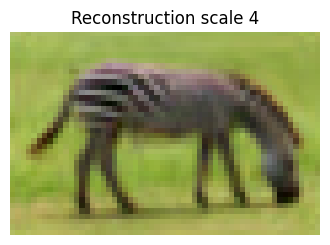

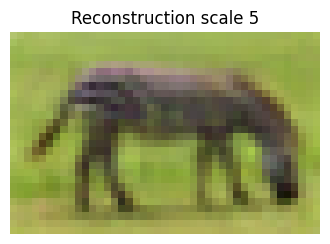

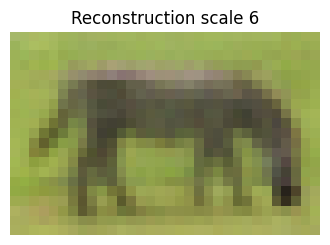

In [19]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def plot_reconstructions(x_rec, scales):
    for i, rec in enumerate(x_rec):
        if rec is None:
            continue
        img = rec.detach().cpu().squeeze()
        plt.figure(figsize=(4,4))
        plt.title(f"Reconstruction scale {i}")
        plt.imshow(pil_from_minus1to1(img))
        plt.axis('off')
        plt.show()

plot_reconstructions(x_rec[1:],scales)